## Airfoil Generation via VAE & GAN 
UIUC Airfoil Coordinates Database includes coordinates for nearly 1,600 airfoils. Since number of points in each sample differ, we first process all airfoils to have 200 points and share the same x coordinates via spline interpolation. Also, all y coordinates are rescaled to [-1,1]. Therefore, only y coordinates of each airfoil is used to train and test generative models.

In this problem, we build, train and test a VAE model as well as a GAN model via PyTorch. 

In [1]:
# DATASET LOADING AND PROCESSING (DO NEED TO MODIFY)
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
import torch.nn.functional as F

def plot_airfoils(airfoil_x, airfoil_y):
    '''
    plot airfoils: no need to modify 
    '''
    idx = 0
    fig, ax = plt.subplots(nrows=4, ncols=4)
    for row in ax:
        for col in row:
            col.scatter(airfoil_x, airfoil_y[idx, :], s=0.6, c='black')
            col.axis('off')
            col.axis('equal')
            idx += 1
    plt.show()


class AirfoilDataset(Dataset):
    '''
    airfoil dataset: no need to modify
    '''
    def __init__(self, path='./airfoils'):
        super(AirfoilDataset, self).__init__()
        self._X = []	# x coordinates of all airfoils (shared)
        self._Y = []	# y coordinates of all airfoils
        self.names = []	# name of all airfoils
        self.norm_coeff = 0	# normalization coeff to scale y to [-1, 1]
        airfoil_fn = [afn for afn in os.listdir(path) if afn.endswith('.dat')]

        # get x coordinates of all airfoils
        with open(os.path.join(path, airfoil_fn[0]), 'r', encoding="utf8", errors='ignore') as f:
            raw_data = f.readlines()
            for idx in range(len(raw_data)):
                raw_xy = raw_data[idx].split(' ')
                while "" in raw_xy:
                    raw_xy.remove("")
                self._X.append(float(raw_xy[0]))
        self._X = np.array(self._X)

        # get y coordinates of each airfoils
        for idx, fn in enumerate(airfoil_fn):
            with open(os.path.join(path, fn), 'r', encoding="utf8", errors='ignore') as f:
                self.names.append(fn[:-10])
                raw_data = f.readlines()
                airfoil = np.empty(self._X.shape[0])
                for i in range(len(raw_data)):
                    raw_xy = raw_data[i].split(' ')
                    while "" in raw_xy:
                        raw_xy.remove("")
                    curr_y = float(raw_xy[1])
                    airfoil[i] = curr_y
                    self.norm_coeff = max(self.norm_coeff, np.abs(curr_y))
                self._Y.append(airfoil)

        self._Y = np.array([airfoil / self.norm_coeff for airfoil in self._Y], dtype=np.float32)

    def get_x(self):
        '''
        get shared x coordinates
        '''
        return self._X

    def get_y(self):
        '''
        get y coordinates of all airfoils
        '''
        return self._Y

    def __getitem__(self, idx):
        return self._Y[idx], self.names[idx]

    def __len__(self):
        return len(self._Y)

# VAE

In [2]:
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        # build model here
        # model should output a predicted mean and a predicted std of the encoding
        # both should be of dim (batch_size, latent_dim)
        
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3_mean = nn.Linear(64, latent_dim)
        self.fc3_logvar = nn.Linear(64, latent_dim)
    
    def forward(self, x):
        # define feedforward pass
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc3_mean(h), self.fc3_logvar(h)


class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Decoder, self).__init__()
        # build model here
        #  output should be of dim (batch_size, output_dim)
        # we can use tanh() as the activation for the last layer
        # since y coord of airfoils range from -1 to 1
        
        self.fc1 = nn.Linear(latent_dim, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, output_dim)
    
    def forward(self, x):
        # define feedforward pass
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return torch.tanh(self.fc3(h))


class VAE(nn.Module):
    def __init__(self, airfoil_dim, latent_dim):
        super(VAE, self).__init__()
        self.enc = Encoder(airfoil_dim, latent_dim)
        self.dec = Decoder(latent_dim, airfoil_dim)
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        # define feedforward pass
        mu, logvar = self.enc(x.view(-1, airfoil_dim))
        z = self.reparameterize(mu, logvar)
        return self.dec(z), mu, logvar

    def decode(self, z):
        # given random noise z, generate airfoils
        return self.dec(z)

In [3]:
# check if cuda available
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

batch_size = 20
# define dataset and dataloader
dataset = AirfoilDataset()
airfoil_x = dataset.get_x()
airfoil_dim = airfoil_x.shape[0]
airfoil_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# hyperparameters
latent_dim = 16 # please do not change latent dimension
lr = 0.001 #0.003      # learning rate
num_epochs = 100 #100
weight_decay = 1.e-5

# build the model
vae = VAE(airfoil_dim=airfoil_dim, latent_dim=latent_dim).to(device)
print("VAE model:\n", vae)

# define your loss function here
def vae_loss(recon_x, x, mu, logvar):
    # MSE Loss
    MSE = F.mse_loss(recon_x, x.view(-1, airfoil_dim), reduction='sum')
    
    # KL Divergence Loss
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return MSE + 0.0001 * KLD


# define optimizer for discriminator and generator separately
optim = Adam(vae.parameters(), lr=lr, weight_decay=weight_decay)
epoch_losses = []
# train the VAE model
for epoch in range(num_epochs):
    
    epoch_loss = 0.0
    num_batches = 0
    
    
    for n_batch, (local_batch, __) in enumerate(airfoil_dataloader):
        y_real = local_batch.to(device)

        # train VAE
        recon_airfoils, mu, logvar = vae(y_real)
        loss = vae_loss(recon_airfoils, y_real, mu, logvar)
        # calculate customized VAE loss
        # loss = your_loss_func(...)

        optim.zero_grad()
        loss.backward()
        optim.step()
        
        epoch_loss += loss.item()
        num_batches += 1
        # print loss while training
        if (n_batch + 1) % 100 == 0:
            print("Epoch: [{}/{}], Batch: {}, loss: {}".format(
                epoch, num_epochs, n_batch, loss.item()))
            
    avg_loss = epoch_loss / num_batches
    epoch_losses.append(avg_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Average Loss: {avg_loss:.4f}")
 

VAE model:
 VAE(
  (enc): Encoder(
    (fc1): Linear(in_features=200, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=64, bias=True)
    (fc3_mean): Linear(in_features=64, out_features=16, bias=True)
    (fc3_logvar): Linear(in_features=64, out_features=16, bias=True)
  )
  (dec): Decoder(
    (fc1): Linear(in_features=16, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=200, bias=True)
  )
)
Epoch [1/100], Average Loss: 30.7664
Epoch [2/100], Average Loss: 7.4810
Epoch [3/100], Average Loss: 2.1201
Epoch [4/100], Average Loss: 1.8477
Epoch [5/100], Average Loss: 1.7850
Epoch [6/100], Average Loss: 1.7528
Epoch [7/100], Average Loss: 1.7264
Epoch [8/100], Average Loss: 1.6778
Epoch [9/100], Average Loss: 1.6680
Epoch [10/100], Average Loss: 1.6329
Epoch [11/100], Average Loss: 1.5062
Epoch [12/100], Average Loss: 1.2064
Epoch [13/100], Average Loss: 1.1088
Epoch [14/10

real_airfoils:


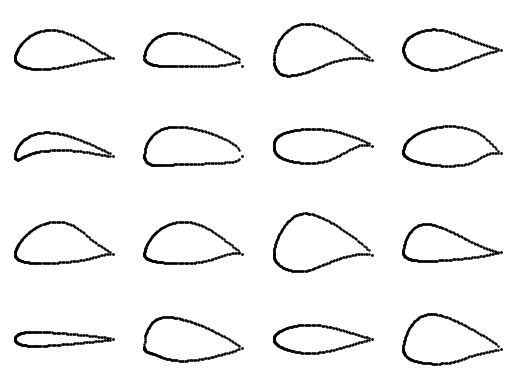

recon_airfoils


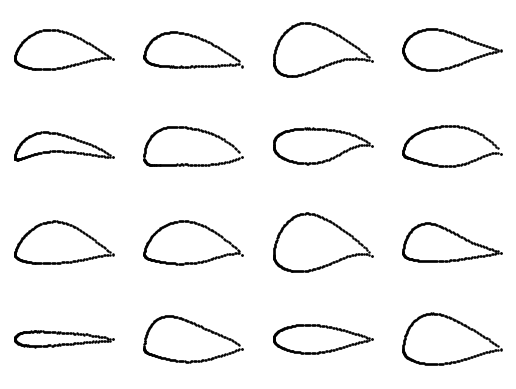

gen_airfoils


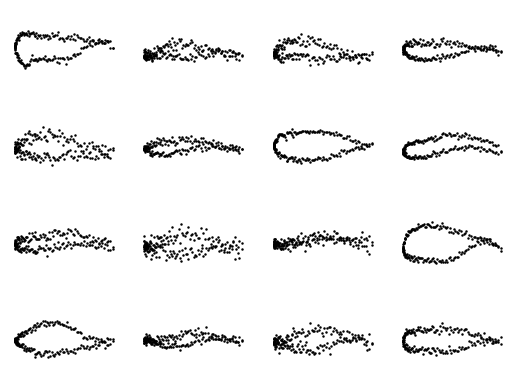

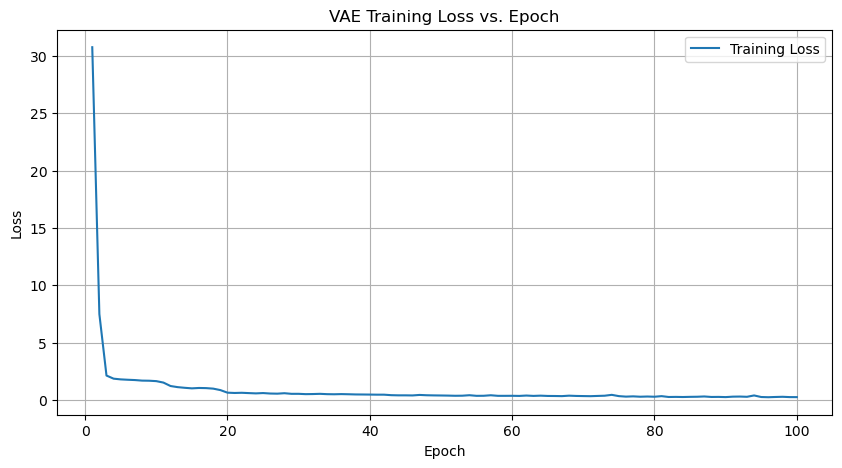

In [4]:
   

# test trained VAE model
num_samples = 100

# reconstuct airfoils
real_airfoils = dataset.get_y()[:num_samples]
recon_airfoils, __, __ = vae(torch.from_numpy(real_airfoils).to(device))
if 'cuda' in device:
    recon_airfoils = recon_airfoils.detach().cpu().numpy()
else:
    recon_airfoils = recon_airfoils.detach().numpy()

# randomly synthesize airfoils
noise = torch.randn((num_samples, latent_dim)).to(device)   # create random noise 
gen_airfoils = vae.decode(noise)
if 'cuda' in device:
    gen_airfoils = gen_airfoils.detach().cpu().numpy()
else:
    gen_airfoils = gen_airfoils.detach().numpy()

# plot real/reconstructed/synthesized airfoils
print("real_airfoils:")
plot_airfoils(airfoil_x, real_airfoils)
print("recon_airfoils")
plot_airfoils(airfoil_x, recon_airfoils)

print("gen_airfoils")
plot_airfoils(airfoil_x, gen_airfoils)


plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), epoch_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VAE Training Loss vs. Epoch')
plt.legend()
plt.grid(True)
plt.show()


# GAN

In [5]:
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        # build your model here
        # your output should be of dim (batch_size, 1)
        # since discriminator is a binary classifier
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
    
    
    def forward(self, x):
        # define your feedforward pass
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        return torch.sigmoid(self.fc3(x))


class Generator(nn.Module):
    def __init__(self, latent_dim, airfoil_dim):
        super(Generator, self).__init__()
        # Define the architecture of the generator
        # This is a simple feed-forward network with three linear layers
        self.fc1 = nn.Linear(latent_dim, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, airfoil_dim)
    
    def forward(self, x):
        # Feedforward pass through the network
        x = F.leaky_relu(self.fc1(x), 0.2)  # Use leaky ReLU for the generator
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = torch.tanh(self.fc3(x))  # tanh activation to output values between -1 and 1
        return x

Distrminator model:
 Discriminator(
  (fc1): Linear(in_features=200, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)
Generator model:
 Generator(
  (fc1): Linear(in_features=16, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=200, bias=True)
)


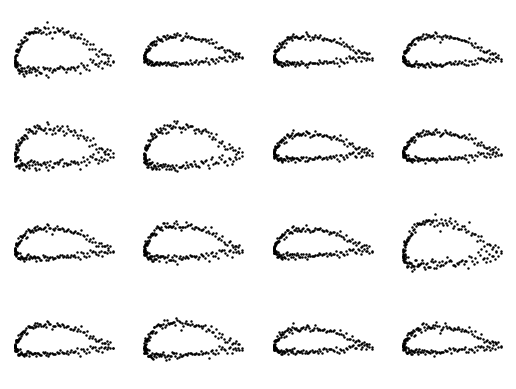

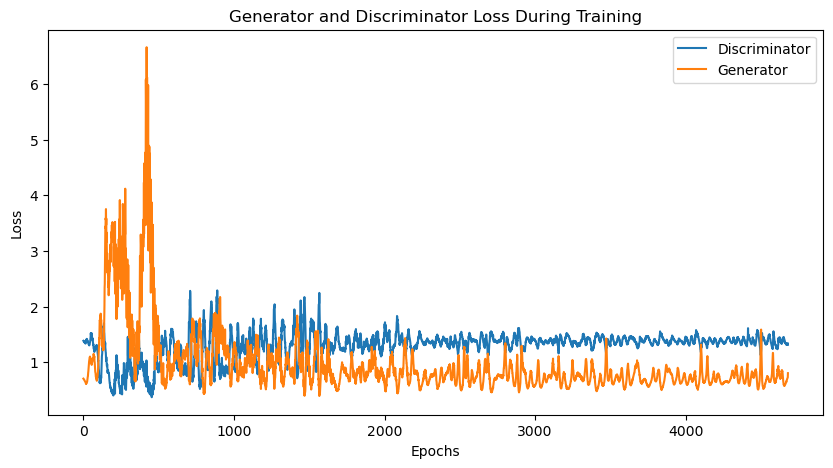

In [6]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
batch_size = 20
# define dataset and dataloader
dataset = AirfoilDataset()
airfoil_x = dataset.get_x()
airfoil_dim = airfoil_x.shape[0]
airfoil_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# hyperparameters
latent_dim = 16 # do not change latent dimension
lr_dis = 0.0005 # discriminator learning rate
lr_gen = 0.0005 # generator learning rate
num_epochs = 60
weight_decay_dis = 1.e-5
weight_decay_gen = 1.e-5

# build the model
dis = Discriminator(input_dim=airfoil_dim).to(device)
gen = Generator(latent_dim=latent_dim, airfoil_dim=airfoil_dim).to(device)
print("Distrminator model:\n", dis)
print("Generator model:\n", gen)

# define your GAN loss function here
# you may need to define your own GAN loss function/class
loss =  nn.BCELoss()

# define optimizer for discriminator and generator separately
optim_dis = Adam(dis.parameters(), lr=lr_dis, weight_decay=weight_decay_dis)
optim_gen = Adam(gen.parameters(), lr=lr_gen, weight_decay=weight_decay_gen)



discriminator_losses = []
generator_losses = []


# train the GAN model
for epoch in range(num_epochs):
    for n_batch, (local_batch, _) in enumerate(airfoil_dataloader):
        y_real = local_batch.to(device)
        current_batch_size = y_real.size(0)  # Get the current batch size

        # Train Discriminator
        label_real = torch.ones(current_batch_size, 1).to(device)  # Adjust the size of label_real
        label_fake = torch.zeros(current_batch_size, 1).to(device)  # Adjust the size of label_fake

        dis.zero_grad()
        output_real = dis(y_real)
        loss_real = loss(output_real, label_real)

        noise = torch.randn(current_batch_size, latent_dim).to(device)  # Adjust noise to current batch size
        y_fake = gen(noise)
        output_fake = dis(y_fake.detach())
        loss_fake = loss(output_fake, label_fake)

        loss_dis = loss_real + loss_fake
        loss_dis.backward()
        optim_dis.step()

        # Train Generator
        gen.zero_grad()
        output_fake = dis(y_fake)
        loss_gen = loss(output_fake, label_real)  # Use the dynamically sized label_real
        loss_gen.backward()
        optim_gen.step()
        
        
        discriminator_losses.append(loss_dis.item())
        generator_losses.append(loss_gen.item())
        
        
        if (n_batch + 1) % 100 == 0:
            print(f"Epoch: [{epoch+1}/{num_epochs}], Batch: {n_batch+1}, Discriminator Loss: {loss_dis.item():.4f}, Generator Loss: {loss_gen.item():.4f}")
# test trained GAN model
num_samples = 500
# create random noise 
noise = torch.randn((num_samples, latent_dim)).to(device)
# generate airfoils
gen_airfoils = gen(noise)
if 'cuda' in device:
    gen_airfoils = gen_airfoils.detach().cpu().numpy()
else:
    gen_airfoils = gen_airfoils.detach().numpy()

# plot generated airfoils
plot_airfoils(airfoil_x, gen_airfoils)



plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(discriminator_losses, label="Discriminator")
plt.plot(generator_losses, label="Generator")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


# Tune hyperparameters both in the model and optimizer to improve the performance:

Hyperparameters have been tuned to improve the performance. For example, for GAN model, lr = 0.0005 with batch size of 20 has been used. 
Also, number of epochs has been increased to 100 for VAE to get better convergence. Additionally, batch size of 20 is used for VAE.


# Hyperparameters of VAE is as below:
Adam optimizer with latent_dim = 16, lr = 0.001, num_epochs = 100, batch_size = 20, learning rate decay = 1.e-5

# Hyperparameters of GAN is as below:
Adam optimizer with latent_dim = 16, lr = 0.0005 , num_epochs = 60 , batch size = 20, learning rate decay = 1.e-5 (for both discriminator and generator)



# Comparing synthesized airfoils from a VAE and a GAN:

VAE-generated airfoils is smoother but less sharp, offering a broad variety of shapes. 

GAN-generated airfoils tend to be more detailed and realistic, though they might suffer from less diversity due to potential mode collapse. GANs can be trickier to train and might not interpolate as smoothly as VAEs.

VAEs provide stable training and meaningful interpolation in the latent space.



In [7]:
torch.save(vae.state_dict(), 'p1_vae_model.pth')


In [8]:
state = {
    'generator': gen.state_dict(),
    'discriminator': dis.state_dict()
}
torch.save(state, 'p1_gan_model.pth')
